In [1]:
import pandas as pd
import os
from os.path import exists
import torch
import torch.nn as nn
from torch.nn.functional import log_softmax, pad
import math
import copy
import time
from torch.optim.lr_scheduler import LambdaLR
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import spacy
import GPUtil
import warnings
from torch.utils.data.distributed import DistributedSampler
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP
# Set to False to skip notebook execution (e.g. for debugging)
warnings.filterwarnings("ignore")
RUN_EXAMPLES = True



In [2]:
#读入数据
train_df = pd.read_csv("train.csv", sep=",")
train_df = train_df.dropna(subset=["seq"])
train_df = train_df[train_df["seq"].apply(len) <= 2000].reset_index(drop=True)
test_df = pd.read_csv("train.csv", sep=",")
test_df = test_df.dropna(subset=["seq"])
test_df = test_df[test_df["seq"].apply(len) <= 2000].reset_index(drop=True)

In [3]:
max_len = train_df["seq"].str.len().max()
print(max_len)


1970


In [4]:
MAX_LEN = 2000
num_long = (train_df["seq"].apply(len) > MAX_LEN).sum()
print(max(train_df["seq"].apply(len)))
print(f"长度 > {MAX_LEN} 的序列数:", num_long)


1970
长度 > 2000 的序列数: 0


In [5]:
#进行向量化--dataset
class Tokenize(Dataset):
    def __init__(self, df):
        self.src = df["seq"].tolist()
        self.dssp8 = df["dssp8"].tolist()
        self.dssp3 = df["dssp3"].tolist()

        self.src_stoi,self.src_size = self.build_vocab(set("".join(self.src)))
        self.dssp8_stoi,self.dssp8_size = self.build_vocab(set("".join(self.dssp8)))
        self.dssp3_stoi,self.dssp3_size = self.build_vocab(set("".join(self.dssp3)))

    def build_vocab(self, vocab_set):
        vocab_list = ["<pad>", "<unk>","<bos>", "<eos>"] + sorted(list(vocab_set))
        stoi = {s: i for i, s in enumerate(vocab_list)}
        return stoi, len(vocab_list)

    def encode(self, text, stoi):
        ids = [stoi["<bos>"]]
        for ch in text:
            ids.append(stoi.get(ch, stoi["<unk>"]))
        ids.append(stoi["<eos>"])
        return torch.tensor(ids, dtype=torch.long)

    def __len__(self):
        return len(self.src)

    def __getitem__(self, idx):
        return (
            self.encode(self.src[idx], self.src_stoi),
            self.encode(self.dssp8[idx], self.dssp8_stoi),
            self.encode(self.dssp3[idx], self.dssp3_stoi))

In [6]:
print(Tokenize(train_df).src_size)
print(Tokenize(train_df).dssp3_stoi)

25
{'<pad>': 0, '<unk>': 1, '<bos>': 2, '<eos>': 3, 'C': 4, 'E': 5, 'H': 6}


In [ ]:

#批次处理--dataloader
def collate_fn(batch, pad_idx):
    srcs,dssp8,dssp3 = zip(*batch)
    max_srcs = max(len(x) for x in srcs)
    max_dssp8 = max(len(x) for x in dssp8)
    max_dssp3 = max(len(x) for x in dssp3)

    src_pad = torch.full((len(batch), max_srcs),pad_idx)
    dssp8_pad = torch.full((len(batch), max_dssp8),pad_idx)
    dssp3_pad = torch.full((len(batch), max_dssp3),pad_idx)

    for i in range(len(batch)):
        src_pad[i, :len(srcs[i])] = srcs[i]
        dssp8_pad[i, :len(dssp8[i])] = dssp8[i]
        dssp3_pad[i, :len(dssp3[i])] = dssp3[i]
        
    return src_pad, dssp8_pad, dssp3_pad
#input=(nrow,(3,n_str))
#output=3×(nbatch,n_str)


#Embedding层
class Embeddings(nn.Module):
    def __init__(self, vocab, d_model, pad_idx=0):
        super(Embeddings,self).__init__()
        self.lut = nn.Embedding(vocab, d_model, pad_idx)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x)*math.sqrt(self.d_model)
#input=(nbatch,n_str)
#output=(nbatch,n_str，d_model)

#位置编码
class PositionEmbedding(nn.Module):
    def __init__(self, max_len, d_model):
        super().__init__()
        self.pos_emb = nn.Embedding(max_len, d_model)

    def forward(self, x):
        B,L = x.shape[:2]
        pos = torch.arange(L, device=x.device).unsqueeze(0).expand(B, L)
        return self.pos_emb(pos)
#input=(nbatch,n_str)
#output= (nbatch,n_str,d_model)

#深度克隆
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

#QKV矩阵层
class QKV_matrix(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.linears = clones(nn.Linear(d_model, d_model), 3)
    
    def forward(self, x):
        query = self.linears[0](x)
        key = self.linears[1](x)
        value = self.linears[2](x)
        return query, key, value
#input=(nbatch,n_str,d_model)
#output=3×(nbatch,n_str,d_model)

#注意力算法

def attention(query, key, value, dropout):
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2,-1))/math.sqrt(d_k)
    p_attn = scores.softmax(dim=-1)
    p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn
#input=3×(nbatch,n_str,d_model)
#output=(nbatch,n_str,n_str)


#多头注意力层
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        super().__init__()
        self.d_k = d_model//h
        self.h = h
        self.dropout = nn.Dropout(p=dropout)
        self.qkv = QKV_matrix(d_model)
        self.out = nn.Linear(d_model, d_model)

    def forward(self, x):
        nbatch, n_str, _ = x.shape
        query, key, value = self.qkv(x)
        query = query.view(nbatch, n_str, self.h, self.d_k).transpose(1,2)
        key = key.view(nbatch, n_str, self.h, self.d_k).transpose(1,2)
        value = value.view(nbatch, n_str, self.h, self.d_k).transpose(1,2)
        x,attn = attention(query, key, value, dropout=self.dropout)
        x = x.transpose(1,2).contiguous().view(nbatch, n_str, self.h*self.d_k)
        del query
        del key
        del value
        return self.out(x)
#input=原始(nbatch，n_str,d_model)
#output->W_q,W_k,W_v(d_model,d_model)->QKV(nbatch，n_str,d_model)->attention(nbatch,n_head,n_str,n_str)×(nbatch,n_head,n_str,d_model)
#(nbatch,n_str,d_model)

#卷积层
#我希望它在通过注意力机制后看完全局的数据之间的相互关系后，重新关注周围的氨基酸序列对于二级结构序列的预测
#我设计的卷积核是3 5 7并行的并且我希望让它自己去学习出哪种卷积核的设计更合理
#这样设计因为蛋白质的二级结构的残基对于α螺旋来说是3.6为一个周期，对于β折叠来说是3为一个周期，对于loop来说是5为一个周期

class MultiConv(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.conv3 = nn.Conv1d(d_model, d_model, kernel_size=3, padding=1)
        self.conv5 = nn.Conv1d(d_model, d_model, kernel_size=5, padding=2)
        self.conv7 = nn.Conv1d(d_model, d_model, kernel_size=7, padding=3)
        self.conv_all = nn.Conv1d(3*d_model, d_model, kernel_size=1)
        self.act_fun = nn.SiLU()
        self.norm = nn.BatchNorm1d(d_model)


    def forward(self, x):
        x = x.transpose(1,2)
        #conv矩阵的限制
        x3 = self.conv3(x)
        x5 = self.conv5(x)
        x7 = self.conv7(x)
        x = torch.cat([x3, x5, x7], dim=1)
        x = self.conv_all(x)
        x = self.act_fun(x)
        x = self.norm(x)

        return x.transpose(1, 2)
        
#标准化层
class LayerNorm(nn.Module):
    def __init__(self, d_model, eps=1e-6):
        super().__init__()
        self.a_2 = nn.Parameter(torch.ones(d_model))
        self.b_2 = nn.Parameter(torch.zeros(d_model))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2*(x - mean)/(std + self.eps) + self.b_2
#input=(nbatch,n_str,d_model)对d_model进行标准化，让它朝向某一特定的方向发生一定的偏移
#output=(nbatch,n_str,d_model)

#残差化层
class Residual(nn.Module):
    def __init__(self, d_model, dropout):
        super().__init__()  
        self.norm = LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))
#input=(nbatch,n_str,d_model)
#output=(nbatch,n_str,d_model)

#前向传播层
class PositionFeedForward(nn.Module):
    def __init__(self, d_model, d_ff,dropout=0.1):
        super().__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self,x):
        return self.w_2(self.dropout(self.w_1(x).relu()))
#input=(nbatch,n_str,d_model)
#output=(nbatch,n_str,d_model)


class  Encoderlayer(nn.Module):
    def __init__(self, d_model, attn, feed_forward, Conv,dropout):
        super().__init__()
        self.attn = attn
        self.feed_forward = feed_forward
        self.Conv = Conv 
        self.sublayer = clones(Residual(d_model,dropout),3)
        self.d_model = d_model

    def forward(self, x):
        x = self.sublayer[0](x, lambda x: self.attn(x))
        x = self.sublayer[1](x, self.Conv)
        return self.sublayer[2](x, self.feed_forward)



class Generator(nn.Module):
    def __init__(self, d_model, n_classes):
        super().__init__()
        self.proj = nn.Linear(d_model, n_classes)

    def forward(self, x):
        return self.proj(x)
#input=(nbatch,n_str,d_model)
#output=(nbatch,n_str,n_proj)


In [8]:
class ProteinTransformer(nn.Module):
    def __init__(
        self,
        vocab_size,
        n_classes,
        d_model,
        d_ff,
        n_head,
        n_layers,
        dim_feedforward,
        max_len=2000,
        pad_idx=0,
        dropout=0.1
    ):
        super().__init__()
        self.embed = Embeddings(vocab_size, d_model, pad_idx)
        self.pos_embed = PositionEmbedding(max_len, d_model)
        self.dropout = nn.Dropout(dropout)
        self.encoder = clones(Encoderlayer(d_model, 
                                           MultiHeadedAttention(n_head, d_model),
                                           PositionFeedForward(d_model, d_ff),
                                           MultiConv(d_model), dropout),
                              n_layers)
        self.generator = Generator(d_model, n_classes)
        self.pad_idx = pad_idx

    def forward(self, x):
        x = self.embed(x) + self.pos_embed(x)
        x = self.dropout(x)
        for layer in self.encoder:
            x = layer(x)
        logits = self.generator(x)
        return logits

#input=(nbatch,n_str,d_model)
#output=(nbatch,n_str,n_proj)


In [ ]:
#整体框架
class Loss(nn.Module):
    def __init__(self,pad_idx):
        super().__init__()
        self.criterion = nn.CrossEntropyLoss(ignore_index = pad_idx)

    def forward(self, logits, targets):
        B,L,C = logits.shape
        return self.criterion(logits.view(B*L, C),targets.view(B*L))
#input=(nbatch,n_str,n_proj)
#output=str_loss 

class Trainer:
    def __init__(self, model, criterion, optimizer, device):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
    def train_step(self, batch):
        src, _, dssp3 = batch
        
        src = src.to(self.device)
        dssp3 = dssp3.to(self.device)
        self.optimizer.zero_grad()
        logits = self.model(src)
        loss = self.criterion(logits, dssp3)
        loss.backward()
        self.optimizer.step()
        return loss.item()



In [11]:
#开始运行
dataset = Tokenize(train_df)
train_loader = DataLoader(
    dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=lambda batch: collate_fn(batch, pad_idx=0)
)

batch = next(iter(train_loader))
src, _, dssp3 = batch


In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

model = ProteinTransformer(
        vocab_size=dataset.src_size,
        n_classes=dataset.dssp3_size,
        d_model=128,
        d_ff = 256,
        n_head=4,
        n_layers=3,
        dim_feedforward=512,
        max_len=2000,
        pad_idx=0,
        dropout=0.1
    ).to(torch.device("cuda"))
criterion = Loss(0)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=3e-5,
    betas=(0.9, 0.98),
    eps=1e-9
)#优化器--这里可以试一试优化成别的算法
trainer = Trainer(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    device=torch.device("cuda")
)

num_epochs = 1
log_interval = 10
losses = []
steps = []
for epoch in range(1, num_epochs + 1):
    for step, batch in enumerate(train_loader):
        loss = trainer.train_step(batch)
        losses.append(loss)
        steps.append(step+(epoch-1)*len(train_loader))
        if step % log_interval == 0:
            print(
                f"[Epoch {epoch}] "
                f"Step {step}/{len(train_loader)} "
                f"Loss: {loss:.4f}"
            )


# plt.plot(steps,losses)
# plt.xlabel('Steps')
# plt.ylabel('Loss')
# plt.title('Training Loss Curve')
# plt.grid(True)
# plt.show()

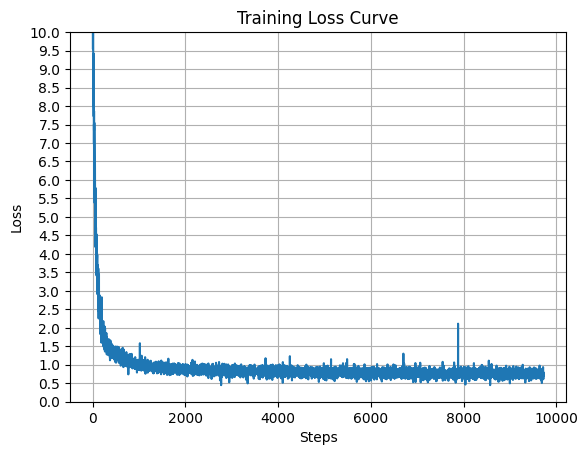

In [13]:
plt.plot(steps,losses)
plt.ylim(0, 10)  
plt.locator_params(axis='y', nbins=20)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.savefig('Transformer_dssp3_CNN_baseline.png') 

In [ ]:

import torch
import os

save_dir = "./checkpoints"
os.makedirs(save_dir, exist_ok=True)

# 保存模型权重
torch.save(model.state_dict(), os.path.join(save_dir, "Transformer_dssp3_CNN_baseline.pt"))
print("Transformer_CNN_baseline.pt")

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, os.path.join(save_dir, "Transformer_dssp3_CNN_optimizer.pt"))

import pickle

train_log_path = os.path.join(save_dir, "Transformer_dssp3_CNN_baseline.pkl")
with open(train_log_path, "wb") as f:
    pickle.dump({"losses": losses, "steps": steps}, f)

print("Transformer_CNN_baseline.pkl")


模型权重已保存：Transformer_CNN_baseline.pt
训练日志已保存：Transformer_CNN_baseline.pkl


In [ ]:
model = ProteinTransformer(
        vocab_size=dataset.src_size,
        n_classes=dataset.dssp3_size,
        d_model=128,
        d_ff = 256,
        n_head=4,
        n_layers=3,
        dim_feedforward=512,
        max_len=2000,
        pad_idx=0,
        dropout=0.1
    ).to(torch.device("cuda"))

state_dict = torch.load("./checkpoints/Transformer_dssp3_CNN_baseline.pt", map_location=torch.device("cuda"))
model.load_state_dict(state_dict)
model.eval()   

ProteinTransformer(
  (embed): Embeddings(
    (lut): Embedding(25, 128, padding_idx=0)
  )
  (pos_embed): PositionEmbedding(
    (pos_emb): Embedding(2000, 128)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (encoder): ModuleList(
    (0-2): 3 x Encoderlayer(
      (attn): MultiHeadedAttention(
        (dropout): Dropout(p=0.1, inplace=False)
        (qkv): QKV_matrix(
          (linears): ModuleList(
            (0-2): 3 x Linear(in_features=128, out_features=128, bias=True)
          )
        )
        (out): Linear(in_features=128, out_features=128, bias=True)
      )
      (feed_forward): PositionFeedForward(
        (w_1): Linear(in_features=128, out_features=256, bias=True)
        (w_2): Linear(in_features=256, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (Conv): MultiConv(
        (conv3): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
        (conv5): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=(2,))

In [16]:
test_dataset = Tokenize(test_df)
test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=True,
    collate_fn=lambda batch: collate_fn(batch, pad_idx=0)
)

In [17]:
correct = 0
total = 0
pad_idx = 0

with torch.no_grad():
    for batch in test_loader:
        src, _, dssp3 = batch
        src = src.to(torch.device("cuda"))
        dssp3 = dssp3.to(torch.device("cuda"))

        logits = model(src)
        preds = logits.argmax(dim=-1)

        mask = (dssp3 != pad_idx)   # [B, L]

        correct += (preds[mask] == dssp3[mask]).sum().item()
        total += mask.sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.6726
